# discrate_ds2


_This notebook describes results of second run of __[Discrate](https://github.com/tsgouvea/discrate/tree/44a5b0aaa673c12397426b7949da4ddf8f641b33)__, a 2AFC task that pitches reward rate against immediacy. In each trial, rats chose freely between two choice ports with different pre- and post-choice delays. Reward probability is 0.5,_ iid _across trials. In the current version, free choice _

In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mp
import scipy.io as sio
import scipy as sp
import statsmodels.api as sm
from IPython.display import display, HTML

from tasks import discrate

/Users/thiago/Programs/anaconda2/envs/tasksuite/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load single sessions (Bpod .mat files stored in same repository as this notebook) and build pandas dataframes with session summary (**dataSumm**) and single trial (**dataSing**) data:

In [2]:
path_ds2 = 'datasets/discrate_ds2/'
listSubj = next(os.walk(path_ds2))[1]
listSubj.sort()
listSess = [[]]*len(listSubj)
dataSumm = discrate.multisess()
dataSing = [[]]*len(listSubj)
indSubj = []
indDate = []

listDs = open(os.path.join('datasets','discrate_ds2.txt'),'w')

for iSubj in range(len(listSubj)) :
    subj = listSubj[iSubj]
    listSess[iSubj] = os.listdir(os.path.join(path_ds2,subj))
    listSess[iSubj].sort()
    dataSing[iSubj] = [[]]*len(listSess[iSubj])
    dates = [[]]*len(listSess[iSubj])
    for iSess in range(len(listSess[iSubj])) :
        sessName = listSess[iSubj][iSess]
        date = re.split('_',listSess[iSubj][iSess])
        dates[iSess] = date[2]
        fname = os.path.join(path_ds2,subj,sessName)
        listDs.write(fname + '\n')
        mysess = sio.loadmat(fname, squeeze_me=True)
        parsed = discrate.parser(mysess)
        parsed.parse()
        dataSumm.append(parsed)
        dataSing[iSubj][iSess] = parsed.parsedData
        indSubj.append(listSubj[iSubj])
        indDate.append(date[2])
        
listDs.close()
dataSumm.summary['subject'] = indSubj
dataSumm.summary['date'] = indDate

In [3]:
sessName

'TG026_Discrate_Mar30_2018_Session1.mat'

## Response rate depends on pre- and post-reward delays

Plot figure 1:

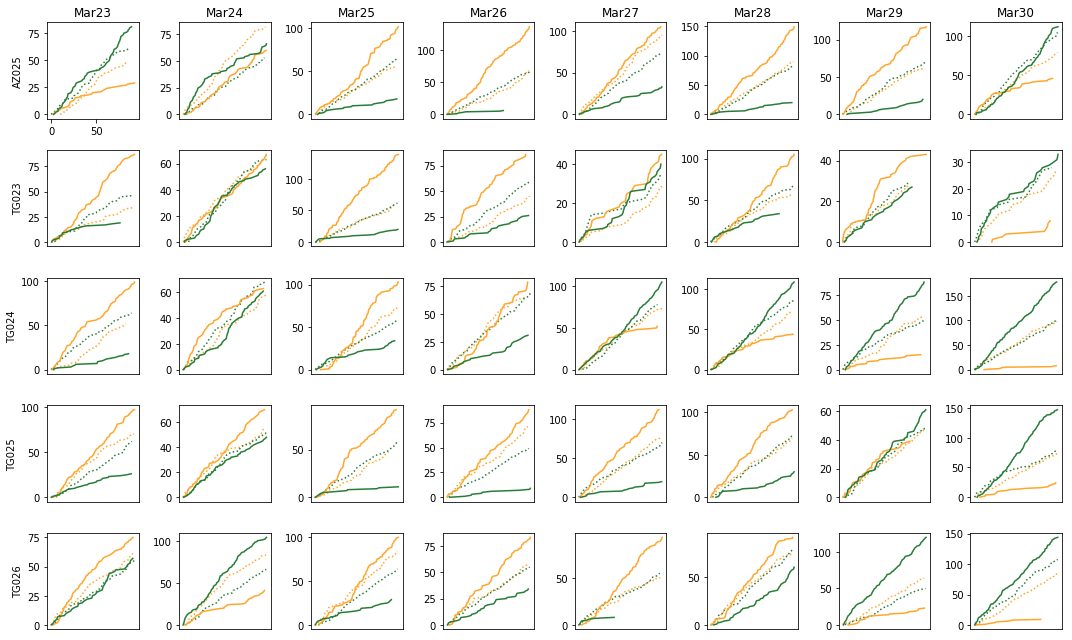

In [4]:
hf, hsps = plt.subplots(len(listSubj),len(listSess[iSubj]),figsize=(15,9))

for iSubj in range(len(listSubj)) :
    for iSess in range(len(listSess[iSubj])) :
        plt.subplot(len(listSubj),len(listSess[iSubj]),1 + (iSubj*len(listSess[iSubj])) + iSess)

        ndxChoL = dataSing[iSubj][iSess].ChoiceLeft.values
        ndxChoR = np.logical_not(ndxChoL)
        ndxForc = dataSing[iSubj][iSess].Forced.values
        
        ndx = np.logical_and(ndxChoL,ndxForc)
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:mango', linestyle=':')
        ndx = np.logical_and(np.logical_not(ndxChoL),ndxForc)
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:darkish green', linestyle=':')
        
        ndx = np.logical_and(ndxChoL,np.logical_not(ndxForc))
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:mango')
        ndx = np.logical_and(np.logical_not(ndxChoL),np.logical_not(ndxForc))
        plt.plot(np.asarray(dataSing[iSubj][iSess].tsState0.values[ndx]-dataSing[iSubj][iSess].tsState0.values[0])/60,np.arange(np.sum(ndx)), color='xkcd:darkish green')
        
        if (iSess > 0 or iSubj > 0) :
            plt.xticks([])
            
        if iSess == 0 :
            plt.ylabel(listSubj[iSubj])
            
        if iSubj == 0 :
            date = re.split('_',listSess[iSubj][iSess])
            plt.title(date[2])

plt.tight_layout()

__Figure 1: Response rates__ Cumulative sum of responses at left (yellow) and right (green) choice ports as a function of time since session start. All sessions lasted 90 min. n = 5 subjects, 9 sessions each.

Display pre- and post- reward delays used in each session:

In [5]:
pivoted = pd.pivot_table(dataSumm.summary,index=['subject','date'])
display(pivoted.loc[:,pivoted.columns[::-1]])

preR  preL  posR  posL     pLeft   logOdds
subject date                                             
AZ025   Mar23   4.0   4.0   8.0   8.0  0.267857 -1.005522
        Mar24   4.0   4.0   8.0   8.0  0.476562 -0.093819
        Mar25   2.0   2.0  32.0   2.0  0.844262  1.690290
        Mar26   2.0   4.0  32.0   2.0  0.951724  2.981344
        Mar27   2.0   4.0  16.0   2.0  0.757143  1.137079
        Mar28   2.0   4.0  16.0   2.0  0.877193  1.966113
        Mar29   2.0   8.0  16.0   2.0  0.848921  1.726162
        Mar30   2.0   8.0   8.0   2.0  0.293750 -0.877240
TG023   Mar23   4.0   4.0   8.0   8.0  0.814815  1.481605
        Mar24   4.0   4.0   8.0   8.0  0.544000  0.176456
        Mar25   2.0   2.0  32.0   2.0  0.869565  1.897120
        Mar26   2.0   4.0  32.0   2.0  0.763158  1.170071
        Mar27   2.0   4.0  16.0   2.0  0.528736  0.115069
        Mar28   2.0   4.0  16.0   2.0  0.751773  1.108091
        Mar29   2.0   8.0  16.0   2.0  0.611111  0.451985
        Mar30   2.0   8.0   8.0   2.0  0.209302 -1.329136
TG024   Mar23   4.0   4.0   8.0   8.0  0.840336  1.660731
        Mar24   4.0   4.0   8.0   8.0  0.507937  0.031749
        Mar25   2.0   2.0  32.0   2.0  0.748201  1.089043
        Mar26   2.0   4.0  32.0   2.0  0.714286  0.916291
        Mar27   2.0   4.0  16.0   2.0  0.333333 -0.693147
        Mar28   2.0   4.0  16.0   2.0  0.290323 -0.893818
        Mar29   2.0   8.0  16.0   2.0  0.152381 -1.716048
        Mar30   2.0   8.0   8.0   2.0  0.047872 -2.990161
TG025   Mar23   4.0   4.0   8.0   8.0  0.784000  1.289131
        Mar24   4.0   4.0   8.0   8.0  0.591667  0.370860
        Mar25   2.0   2.0  32.0   2.0  0.885714  2.047693
        Mar26   2.0   4.0  32.0   2.0  0.898990  2.186051
        Mar27   2.0   4.0  16.0   2.0  0.843284  1.682865
        Mar28   2.0   4.0  16.0   2.0  0.770370  1.210404
        Mar29   2.0   8.0  16.0   2.0  0.392157 -0.438255
        Mar30   2.0   8.0   8.0   2.0  0.144509 -1.778336
TG026   Mar23   4.0   4.0   8.0   8.0  0.567164  0.270290
        Mar24   4.0   4.0   8.0   8.0  0.285714 -0.916291
        Mar25   2.0   2.0  32.0   2.0  0.770992  1.213923
        Mar26   2.0   4.0  32.0   2.0  0.705882  0.875469
        Mar27   2.0   4.0  16.0   2.0  0.912621  2.346070
        Mar28   2.0   4.0  16.0   2.0  0.601307  0.410915
        Mar29   2.0   8.0  16.0   2.0  0.165517 -1.617737
        Mar30   2.0   8.0   8.0   2.0  0.064516 -2.674149

**Table 1: Delays** Delays pre- and post- left and right choices, fraction of left choices, and log odds of choices

## Is choice best explained by pre-, post-, os summed-delays?

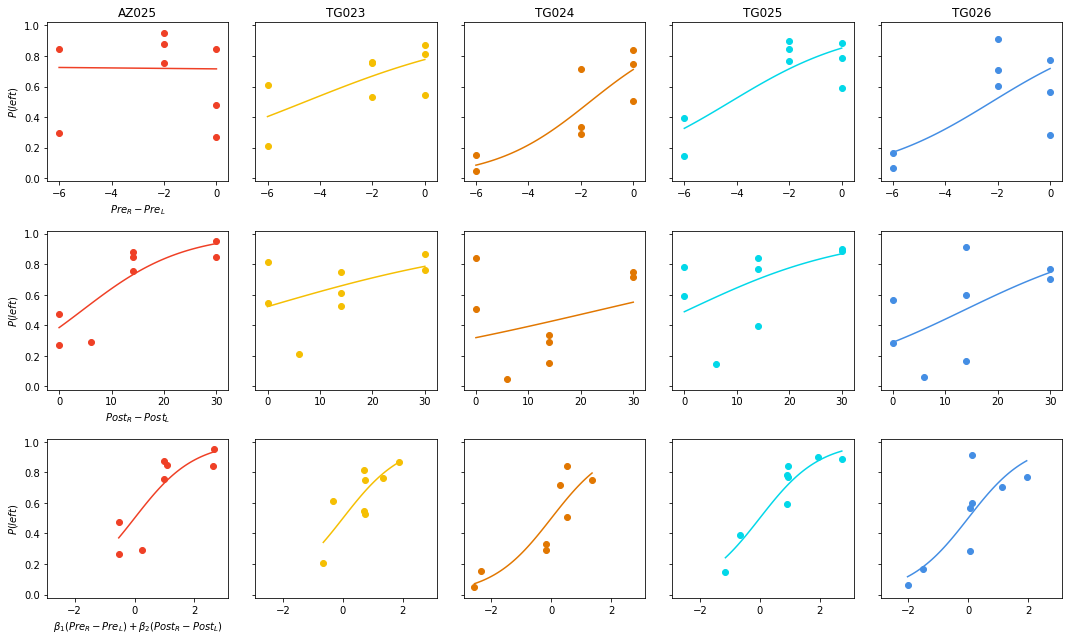

In [6]:
hf, ha = plt.subplots(3,5,sharey='all',sharex='row',figsize=(15,9))
colors = ['xkcd:tomato','xkcd:golden','xkcd:pumpkin','xkcd:aqua blue','xkcd:dark sky blue']
#mdl = [[[*len(listSubj)]*4 ]
mdl = pd.DataFrame(columns=listSubj,index=['pre','post','pre_post'])

for iSubj in range(len(listSubj)) :
    ndxSubj = dataSumm.summary.dropna(how='any').loc[:,'subject'] == listSubj[iSubj]
    
    y = dataSumm.summary.dropna(how='any').loc[ndxSubj,'pLeft']
    yLog = dataSumm.summary.dropna(how='any').loc[ndxSubj,'logOdds']
    X = dataSumm.summary.dropna(how='any')[ndxSubj]
    
    # Model 1: Pre-reward delays
    Xa = pd.Series(list(X.loc[:,'preR'] - X.loc[:,'preL']),name='preR-L',index=X.index)
    mdl.iloc[0,iSubj] = sm.OLS(yLog,sm.add_constant(Xa)).fit()

    # Model 2: Post-reward delays
    Xb = pd.Series(list(X.loc[:,'posR'] - X.loc[:,'posL']),name='posR-L',index=X.index)
    mdl.iloc[1,iSubj] = sm.OLS(yLog,sm.add_constant(Xb)).fit()

    # Model 3: Multivariate (pre- and post- independently)
    Xc = Xa.to_frame()
    Xc[Xb.name] = Xb
    mdl.iloc[2,iSubj] = sm.OLS(yLog,sm.add_constant(Xc)).fit()
    
    # PLOTTING
    ha[0][iSubj].scatter(Xa,y,color=colors[iSubj])
    xcont = np.linspace(Xa.min(),Xa.max(),50)
    ha[0][iSubj].plot(xcont,1/(1+np.exp(-mdl.iloc[0,iSubj].predict(sm.add_constant(xcont)))),color=colors[iSubj])
    ha[0][iSubj].set_title(listSubj[iSubj])
            
    ha[1][iSubj].scatter(Xb,y,color=colors[iSubj])
    xcont = np.linspace(Xb.min(),Xb.max(),50)
    ha[1][iSubj].plot(xcont,1/(1+np.exp(-mdl.iloc[1,iSubj].predict(sm.add_constant(xcont)))),color=colors[iSubj])
    
    M = mdl.iloc[2,iSubj].predict(sm.add_constant(Xc))
    ha[2][iSubj].scatter(M,y,color=colors[iSubj])
    xcont = np.linspace(M.min(),M.max(),50)
    ha[2][iSubj].plot(xcont,1/(1+np.exp(-xcont)),color=colors[iSubj])
    
    if iSubj == 0 :
        ha[0][iSubj].set_xlabel('$Pre_R - Pre_L$')
        ha[0][iSubj].set_ylabel('$P(left)$')
        ha[1][iSubj].set_xlabel('$Post_R - Post_L$')
        ha[1][iSubj].set_ylabel('$P(left)$')
        ha[2][iSubj].set_xlabel(r'$\beta_1(Pre_R - Pre_L) + \beta_2(Post_R - Post_L)$')
        ha[2][iSubj].set_ylabel('$P(left)$')

plt.tight_layout()

__Figure 2: Regresion models for P(choice)__ n = 5 subjects, 9 sessions each. Model specifications:

Model 1: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Pre_R - Pre_L)$

Model 2: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Post_R - Post_L)$

Model 3: $log{\frac{P_L}{(1-P_L)}} = \beta_0 + \beta_1(Pre_R - Pre_L) + \beta_2(Post_R - Post_L)$

Do pre- and post-reward times contribute equally to choice? Impatient subjects would weight pre-reward time more heavily, while reward rate maximazers would favor both equally.

([<matplotlib.axis.XTick at 0x1c2444bd68>,
 <a list of 2 Text xticklabel objects>)

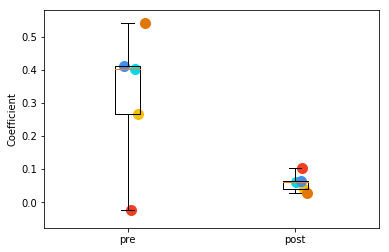

In [7]:
pre = [[]]*len(listSubj)
post = [[]]*len(listSubj)
const = [[]]*len(listSubj)

for iSubj in range(len(listSubj)) :
    const[iSubj], pre[iSubj], post[iSubj] = mdl.iloc[2,iSubj].params
    #print(listSubj[iSubj])
    #print(mdl.iloc[2,iSubj].summary())
    plt.scatter([1, 2]+np.random.randn(2)*.05, [pre[iSubj], post[iSubj] ],color=colors[iSubj],s=100)
    
plt.boxplot([pre,post],whis='range')
plt.ylabel('Coefficient')
plt.xticks([1,2],['pre','post'])

__Figure 3: Pre-reward time counts more.__ Regression coefficients for model 3 (constant not shown). Predictors have the same unit (_seconds_). Data points are single subjects, and colors are as in figure 2.